In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import pathlib
from collections import defaultdict
import os
import numpy as np
import random

In [2]:
def get_antipattern_dict(
    embedding_dir, ignore_dirs=[pathlib.Path('./embeddings/negative_samples')]
):
    antipatterns = list(embedding_dir.glob('*'))
    antipatterns_dict = {}
    for antipattern in antipatterns:
        if antipattern not in ignore_dirs:
            antipatterns_dict[antipattern.name] = list(antipattern.glob('*'))
    return antipatterns_dict

def get_labels(antipatterns_dict):
    labels = defaultdict(lambda: [False, False, False, False, ''])
    name2label = {name: i for name, i in zip(antipatterns_dict, range(len(antipatterns_dict)))}
    label2name = {value: key for key, value in name2label.items()}
    for name, paths in antipatterns_dict.items():
        for path in paths:
            labels[os.path.basename(path)][name2label[name]] = True
            labels[os.path.basename(path)][-1] = path
    return labels, name2label, label2name

def get_embedding(filename):
    return np.array([float(x) for x in filename.open().read().split()])

def get_embeddings(labels):
    for name, values in labels.items():
        labels[name].append(get_embedding(values[-1]).reshape(384, -1))
    return labels

In [22]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

embedding_dir = pathlib.Path('./embeddings')
negative_samples_dir = pathlib.Path('./embeddings/negative_samples')
antipatterns_dict = get_antipattern_dict(embedding_dir)
labels, name2label, label2name = get_labels(antipatterns_dict)
_ = get_embeddings(labels)

In [23]:
negative_samples = random.sample(list(negative_samples_dir.glob('*')), 3000)

In [25]:
for negative_sample in negative_samples:
    embedding = get_embedding(negative_sample).reshape(384, -1)
    labels[negative_sample.name] = [False, False, False, False, negative_sample, embedding]

In [26]:
name2label

{'parallel_inheritance_hierarchies': 0,
 'god_classes': 1,
 'data_class': 2,
 'feature_envy': 3}

In [49]:
pih = {file for file in labels.keys() if labels[file][0]}
gc = {file for file in labels.keys() if labels[file][1]}
dc = {file for file in labels.keys() if labels[file][2]}
fe = {file for file in labels.keys() if labels[file][3]}
ne = {file for file in labels.keys() if not any(labels[file][:4])}
sets = (ne, pih, gc, dc, fe)

In [63]:
from supervenn import supervenn
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10), dpi=1000)
l = ['Negative Samples', 'Parallel Inheritance Hierarchies', 'God Classes', 'Data Class', 'Feature Envy']
supervenn(sets, l, side_plots=True, widths_minmax_ratio=0.5)
plt.savefig('dataset.png')

In [18]:
len(labels.keys())

29530

In [7]:
class PredictionHead(nn.Module):
    def __init__(self, embedding_dim, conv_out_dim, lstm_hidden, n_labels, filter_size=3, drop_rate_conv=0.3, drop_rate_lstm=0.5):
        super(PredictionHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(embedding_dim,
                      conv_out_dim,
                      filter_size,
                      padding=filter_size // 2
                     ),
            nn.ReLU(),
            nn.Dropout(drop_rate_conv)
        )
        self.biLSTM = nn.LSTM(
            input_size=conv_out_dim,
            hidden_size=lstm_hidden,
            bidirectional=True,
            batch_first=True
        )    
        self.out = nn.Linear(2*lstm_hidden, n_labels)
        self.dropout = nn.Dropout(drop_rate_lstm)
    def forward(self, x):
        # Input: Tensor([batch_size, embedding_dim, max_seq])
        
        # Expected: Tensor([batch_size, conv_out_dim, max_seq])
        x = self.conv(x)
        x = self.dropout(x)
        
        # Expected: Tensor([batch_size, max_seq, conv_out_dim])
        x = x.permute(0, 2, 1)
        
        # Expected: Tensor([batch_size, max_seq, 2*hidden_size])
        outputs, (hn, cn) = self.biLSTM(x)
        cat = torch.cat([hn[0], hn[1]], dim=-1)
        res = self.out(self.dropout(cat))
        return res

In [8]:
class EmbeddingDataset(Dataset):
    def __init__(self, labels, names):
        self.labels = labels
        self.names = sorted(names, key=lambda x: self.labels[x][-1].shape[1])
        
    def __getitem__(self, idx):
        *labels, _, emb = self.labels[self.names[idx]]
        return torch.FloatTensor(emb), np.array(labels).astype(int)
    
    def __len__(self):
        return len(self.names)

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(list(labels.keys()), test_size=0.2, random_state=42)

In [10]:
def collate_fn(batch):
    max_sequence_len = max([x[0].shape[1] for x in batch])
    emb_dim = batch[0][0].shape[0]
    sequence_padded = torch.zeros([len(batch), emb_dim, max_sequence_len])
    ys = []
    for i, (X, y) in enumerate(batch):
        sequence_padded[i,:,:X.shape[-1]] = X
        ys.append(y)
    return sequence_padded, torch.Tensor(ys)

In [11]:
from sklearn.metrics import roc_curve
import numpy as np


def get_thresholds_multiclass(predictions, target):
    thresholds = []
    for i in range(predictions.shape[1]):
        fpr, tpr, threshes = roc_curve(target.T[i], predictions.T[i])
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        thresholds.append(threshes[ix])
    return thresholds


# Requires two tensors of size [batch_size, n_classes] and a vector of size [n_classes]
def get_accuracy_multiclass(predictions, target, thresholds=None):
    if thresholds is None:
        thresholds = get_thresholds_multiclass(predictions, target)
    predictions = predictions.T
    target = target.T
    correct = 0
    for i in range(predictions.shape[0]):
        predictions[i] = predictions[i] > thresholds[i]
        correct += np.sum(predictions[i] == target[i])
    return thresholds, correct / (predictions.shape[0] * predictions.shape[1])

In [12]:
def train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds):
    model.train()
    losses_train = []
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        model.zero_grad()
        lbls.append(y)
        X, y = X.to(device), y.to(device)

        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        # compute metrics
        losses_train.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls), thresholds)
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Accuracy [{acc:.2f}]')
    return losses_train

In [13]:
def train_step(model, train_loader, loss_func, optimizer, device):
    model.train()
    losses_train = []
    correct = 0
    total = 0
    pbar = tqdm(train_loader)
    for X, y in pbar:
        model.zero_grad()
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()

        # make predictions
        y = y.reshape(-1).cpu().numpy()
        preds = (torch.sigmoid(out) > 0.5).reshape(-1).detach().cpu().numpy().astype(int)

        # compute metrics
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)
        
        losses_train.append(loss.item())
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    return losses_train

In [14]:
def valid_step(model, valid_loader, loss_func, device):
    losses_valid = []
    correct = 0
    total = 0
    model.eval()
    pbar = tqdm(valid_loader)
    total_preds = []
    total_lbls = []
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        out = model(X)

        loss = loss_func(out, y)
        # make predictions
        preds = (torch.sigmoid(out) > 0.5).reshape(-1).detach().cpu().numpy().astype(int)
        total_preds.append((torch.sigmoid(out) > 0.5).detach().cpu().numpy().astype(int))
        total_lbls.append(y.cpu().numpy())
    
        # compute metrics
        y = y.reshape(-1).cpu().numpy()
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)

        losses_valid.append(loss.item())
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    print(classification_report(np.vstack(total_lbls), np.vstack(total_preds)))
    return losses_valid

In [15]:
from sklearn.metrics import classification_report, f1_score
def valid_step_with_roc(model, train_loader, loss_func, device):
    losses_valid = []
    model.eval()
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        lbls.append(y)
        X, y = X.to(device), y.to(device)

        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        loss = loss_func(out, y)

        # compute metrics
        losses_valid.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls))
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Accuracy [{acc:.2f}]')
    preds = np.vstack(preds)
    thresholds, _ = get_accuracy_multiclass(preds, np.vstack(lbls))
    print(classification_report(np.vstack(lbls), preds))
    return losses_valid, thresholds

In [16]:
batch_size = 16
train_dataset = EmbeddingDataset(labels, train)
valid_dataset = EmbeddingDataset(labels, test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_dim = 384
conv_out_dim = 128
lstm_hidden = 128
n_labels = len(name2label)

lr = 1e-4
epochs = 10
loss_func = nn.BCEWithLogitsLoss()
thresholds = np.repeat(0.5, n_labels)

In [18]:
model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [19]:
name2label

{'parallel_inheritance_hierarchies': 0,
 'god_classes': 1,
 'data_class': 2,
 'feature_envy': 3}

  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       919
           1       0.16      0.99      0.28       674
           2       0.25      0.98      0.40      1277
           3       0.83      1.00      0.91      4909

   micro avg       0.46      0.88      0.60      7779
   macro avg       0.31      0.74      0.40      7779
weighted avg       0.58      0.88      0.66      7779
 samples avg       0.47      0.80      0.55      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       919
           1       0.29      0.97      0.45       674
           2       0.41      0.91      0.56      1277
           3       0.85      1.00      0.92      4909

   micro avg       0.62      0.86      0.72      7779
   macro avg       0.39      0.72      0.48      7779
weighted avg       0.63      0.86      0.71      7779
 samples avg       0.65      0.79      0.68      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       919
           1       0.31      0.95      0.47       674
           2       0.45      0.90      0.60      1277
           3       0.86      0.99      0.92      4909

   micro avg       0.65      0.85      0.74      7779
   macro avg       0.41      0.71      0.50      7779
weighted avg       0.64      0.85      0.72      7779
 samples avg       0.67      0.78      0.69      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.01      0.02       919
           1       0.33      0.95      0.49       674
           2       0.47      0.89      0.61      1277
           3       0.86      0.99      0.92      4909

   micro avg       0.66      0.85      0.75      7779
   macro avg       0.64      0.71      0.51      7779
weighted avg       0.76      0.85      0.73      7779
 samples avg       0.69      0.78      0.70      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.07      0.13       919
           1       0.34      0.95      0.50       674
           2       0.48      0.89      0.62      1277
           3       0.87      0.98      0.92      4909

   micro avg       0.67      0.86      0.75      7779
   macro avg       0.63      0.72      0.54      7779
weighted avg       0.75      0.86      0.74      7779
 samples avg       0.70      0.79      0.71      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.78      0.10      0.18       919
           1       0.35      0.95      0.51       674
           2       0.48      0.89      0.63      1277
           3       0.87      0.98      0.92      4909

   micro avg       0.68      0.86      0.76      7779
   macro avg       0.62      0.73      0.56      7779
weighted avg       0.75      0.86      0.75      7779
 samples avg       0.71      0.79      0.72      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.75      0.12      0.20       919
           1       0.37      0.93      0.53       674
           2       0.50      0.88      0.63      1277
           3       0.87      0.98      0.92      4909

   micro avg       0.69      0.86      0.77      7779
   macro avg       0.62      0.72      0.57      7779
weighted avg       0.75      0.86      0.76      7779
 samples avg       0.72      0.79      0.72      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.75      0.12      0.21       919
           1       0.37      0.92      0.53       674
           2       0.50      0.88      0.64      1277
           3       0.87      0.98      0.92      4909

   micro avg       0.70      0.86      0.77      7779
   macro avg       0.63      0.73      0.58      7779
weighted avg       0.76      0.86      0.76      7779
 samples avg       0.72      0.79      0.73      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      0.13      0.22       919
           1       0.36      0.93      0.52       674
           2       0.50      0.88      0.64      1277
           3       0.88      0.97      0.92      4909

   micro avg       0.69      0.85      0.77      7779
   macro avg       0.63      0.73      0.58      7779
weighted avg       0.76      0.85      0.76      7779
 samples avg       0.71      0.78      0.72      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.78      0.14      0.24       919
           1       0.40      0.91      0.55       674
           2       0.54      0.85      0.66      1277
           3       0.88      0.97      0.92      4909

   micro avg       0.72      0.85      0.78      7779
   macro avg       0.65      0.72      0.59      7779
weighted avg       0.77      0.85      0.77      7779
 samples avg       0.73      0.78      0.73      7779



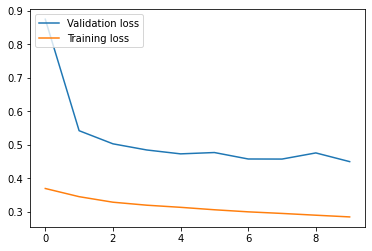

In [21]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step(model, train_loader, loss_func, optimizer, device)
    losses_valid = valid_step(model, valid_loader, loss_func, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))

plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.show()

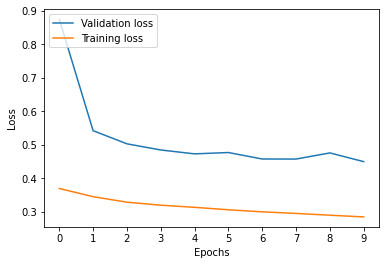

In [22]:
plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('lstm-10-epochs.png', dpi=300)
plt.show()

In [23]:
model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.20      0.56      0.30       919
           1       0.33      0.85      0.47       674
           2       0.44      0.82      0.58      1277
           3       0.90      0.74      0.81      4909

   micro avg       0.54      0.74      0.62      7779
   macro avg       0.47      0.74      0.54      7779
weighted avg       0.69      0.74      0.68      7779
 samples avg       0.53      0.65      0.56      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.21      0.60      0.32       919
           1       0.39      0.92      0.54       674
           2       0.55      0.83      0.66      1277
           3       0.91      0.74      0.82      4909

   micro avg       0.58      0.76      0.66      7779
   macro avg       0.51      0.77      0.58      7779
weighted avg       0.72      0.76      0.71      7779
 samples avg       0.57      0.65      0.58      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.22      0.58      0.32       919
           1       0.40      0.91      0.55       674
           2       0.56      0.82      0.67      1277
           3       0.91      0.76      0.82      4909

   micro avg       0.60      0.76      0.67      7779
   macro avg       0.52      0.77      0.59      7779
weighted avg       0.73      0.76      0.72      7779
 samples avg       0.59      0.66      0.59      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.23      0.59      0.33       919
           1       0.42      0.90      0.57       674
           2       0.58      0.82      0.68      1277
           3       0.91      0.77      0.83      4909

   micro avg       0.61      0.77      0.68      7779
   macro avg       0.53      0.77      0.60      7779
weighted avg       0.73      0.77      0.73      7779
 samples avg       0.60      0.67      0.61      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.23      0.59      0.33       919
           1       0.45      0.89      0.60       674
           2       0.56      0.83      0.67      1277
           3       0.91      0.77      0.83      4909

   micro avg       0.61      0.77      0.68      7779
   macro avg       0.54      0.77      0.61      7779
weighted avg       0.73      0.77      0.73      7779
 samples avg       0.60      0.67      0.61      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.24      0.57      0.34       919
           1       0.44      0.89      0.59       674
           2       0.57      0.83      0.67      1277
           3       0.91      0.75      0.82      4909

   micro avg       0.62      0.76      0.68      7779
   macro avg       0.54      0.76      0.61      7779
weighted avg       0.73      0.76      0.72      7779
 samples avg       0.60      0.66      0.60      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.26      0.53      0.35       919
           1       0.39      0.92      0.55       674
           2       0.56      0.83      0.67      1277
           3       0.91      0.76      0.83      4909

   micro avg       0.62      0.76      0.68      7779
   macro avg       0.53      0.76      0.60      7779
weighted avg       0.73      0.76      0.72      7779
 samples avg       0.60      0.66      0.61      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.26      0.53      0.35       919
           1       0.42      0.90      0.57       674
           2       0.55      0.84      0.67      1277
           3       0.91      0.78      0.84      4909

   micro avg       0.63      0.77      0.70      7779
   macro avg       0.53      0.76      0.61      7779
weighted avg       0.73      0.77      0.73      7779
 samples avg       0.61      0.68      0.62      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.24      0.57      0.34       919
           1       0.42      0.89      0.57       674
           2       0.55      0.85      0.67      1277
           3       0.91      0.74      0.82      4909

   micro avg       0.61      0.75      0.67      7779
   macro avg       0.53      0.76      0.60      7779
weighted avg       0.73      0.75      0.71      7779
 samples avg       0.58      0.65      0.59      7779



  0%|          | 0/1472 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.26      0.55      0.35       919
           1       0.43      0.90      0.58       674
           2       0.56      0.83      0.67      1277
           3       0.91      0.80      0.85      4909

   micro avg       0.64      0.78      0.70      7779
   macro avg       0.54      0.77      0.61      7779
weighted avg       0.73      0.78      0.74      7779
 samples avg       0.62      0.69      0.63      7779



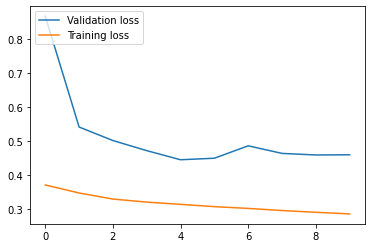

In [24]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds)
    losses_valid, thresholds  = valid_step_with_roc(model, valid_loader, loss_func, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))

plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.show()

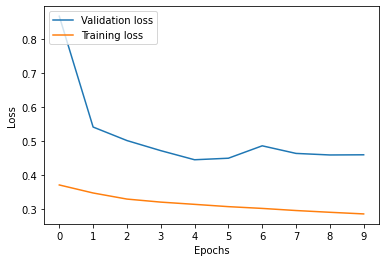

In [25]:
plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('lstm-10-epochs_with_roc_curve.png', dpi=300)
plt.show()